<a href="https://colab.research.google.com/github/Jhc-china/Learning-Notebook/blob/master/Udacity_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow 笔记    (Udacity)


## Tensorflow Dataset 的简单笔记
注：
tensorflow_datasets 组件模型将不再包含在Tensorflow 2.0版本中

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



为了后续能够使用tensorflow部分高级API功能，这里必须在程序的开头使得eager execution可用
eager execution是一种命令式编程环境，可以立即评估操作，无需构建图：

即，操作会立即返回具体的值，而不是构建以后再运行的计算图(动态图)

In [0]:
tf.enable_eager_execution()

###下载数据集并且构造tf.data.Dataset对象

下面我们可以看到tensorflow dataset已经有的所有数据集

In [0]:
tfds.list_builders()

####Dataset的基本操作

#####获取Dataset

split可以是tfds.Split.TRAIN也可以直接是'train'

In [0]:
ds, info = tfds.load('mnist', split=tfds.Split.TRAIN, with_info=True) # ds = dataset, info = dataset info

通过info获取相关元数据的信息
        
可以知道用于Train的样本数为60000，最终的label的种类为10种

In [0]:
print(info.splits['train'].num_examples) # 60000
print(info.features['label'].num_classes) # 10

可以肯定ds一定是tf.data.Dataset对象



In [0]:
assert isinstance(ds, tf.data.Dataset)

上面我们已经将数据集分割了train，如果我们不分割而直接获取dataset，可以通过下面的方法分别获取train和test数据集

且两者均为tf.data.Dataset对象

In [0]:
ds = tfds.load('mnist')
ds_train, ds_test = ds['train'], ds['test']
assert isinstance(ds_train, tf.data.Dataset)
assert isinstance(ds_test, tf.data.Dataset)

不管用上面哪一种，我们都可以尝试获取其中的样本

不过必须首先要让eager execution enabled并且必须在程序开始就启动(因为我们要立即获得操作返回的值)

这样操作会在定义的时候就被执行，要访问Tensor对象具体的值，可以直接通过Tensor对象的numpy()获取对于的ndarray

In [0]:
one_example, = ds.take(1)
image, label = one_example['image'], one_example['label']

plt.imshow(image.numpy()[:,:,0].astype(np.float32), cmap=plt.get_cmap('gray'))
print('Label: %d' % label.numpy())

#####构造数据输入的流程

一个batch包括128个样本，重复10次

In [0]:
ds = ds.batch(128).repeat(10)

如果你愿意的话，可以获得numpy的数组

In [0]:
for ex in tfds.as_numpy(ds): # ex = example
  np_image, np_label = ex['image'], ex['label']

至此，基本的dataset操作如上

####Dataset具体特性

#####DatasetBuilder与Dataset

其实，每一个dataset都暴露为一个DatasetBuilder，该对象有以下几个特征：

1. 知道从哪里下载数据，并且提取数据并将其写入标准格式(DatasetBuilder.download_and_prepare)

2. 知道如何从硬盘中加载数据(DatasetBuilder.as_dataset)

3. 知道关于数据集的所有信息，包括：名字、类型、特征的形状、每一个划分中数据记录的数目、数据集的源URL地址、数据集的引用来源及相关的文献(DatasetBuilder.info)

我们可以直接实例化任何一个DatasetBuilder或者通过tfds.builder以及他们的字符串名字来获取

如下两种方法所示

In [0]:
# 我们再看一下已有的数据库
tfds.list_builders()

In [0]:
# 直接获取数据库
mnist = tfds.image.MNIST()

In [0]:
# 通过字符串名字获取数据
mnist = tfds.builder('mnist')
assert isinstance(mnist, tfds.image.MNIST)

上面两种方法等价

In [0]:
# 无论哪种方法我们都能用DatasetInfo获取具体信息
print('The MNIST datasets version: v', mnist.info.version)
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

The MNIST datasets version: v 1.0.0


In [0]:
# 这个时候我们可以下载这个数据集并做好预处理，然后储存在磁盘上
mnist.download_and_prepare()

as_dataset接受一个输入参数batch_size，设置该参数将会在一次给你一个batch的样本而不是一次只给你一个样本

对于小样本而言，如果内存足够储存，那么可以设置batch_size=-1一次性获取整个数据集(类型为tf.Tensor)

In [0]:
# 然后就可以从磁盘直接直接读取数据集，其类型为tf.data.Datasets
datasets = mnist.as_dataset()
train_dataset, test_dataset = datasets['train'], datasets['test']
assert isinstance(train_dataset, tf.data.Dataset)

所有的tf.data.Datasets都能够通过调用tfds.as_numpy()方便地转化为可迭代的ndarray

In [0]:
# 如果愿意的话，可以将Dataset转化为NumPy数组
for example in tfds.as_numpy(train_dataset):
  image, label = example['image'], example['label']
  assert isinstance(image, np.ndarray)
  break

方便起见，上面的从builder -> download_and_prepare -> as_dataset 都可以用一步tfds.load('dataset_name')来完成，将直接获取tf.data.Datasets
即as_dataset这一步获取的结果

load过程有一些参数可以添加，例如：若with_info=True，则输出第二个参数为该数据集的信息(DatasetInfo)，若split='train'将直接获取训练集(tf.data.Dataset()

更多可见[API文档](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)

In [0]:
datasets = tfds.load('mnist')
train_dataset, test_dataset = datasets['train'], datasets['test']
assert isinstance(train_dataset, tf.data.Dataset)

#####DatasetBuilder配置之Configuration

有不同变种的Datasets将会以BuilderConfigs来对应配置

例如，大型电影评论数据集，tfds.text.IMDBReviews对输入有不同的文本编码格式(例如，纯文本、字符编码、subword编码)

数据集文档中列出了许多内建的配置文件，你可以通过对应的字符名字获取，当然你也可以传入你自己的配置文件

具体如下：

In [0]:
# config为一个dict，有对应的配置类型的版本
configs = tfds.text.IMDBReviews.builder_configs
assert 'bytes' in configs

In [0]:
# 可以直接通过tfds.builder对应的配置名获取配置的DatasetBuilder
imdb = tfds.builder('imdb_reviews/bytes')

<class 'tensorflow_datasets.text.imdb.IMDBReviews'>


In [0]:
# 也可以通过内建方法直接获取DatasetBuilder
imdb = tfds.text.IMDBReviews(config='bytes')

In [0]:
# 或者使用自己配置的配置获取DatasetBuilder
my_encoder = tfds.features.text.ByteTextEncoder(additional_tokens=['hello'])
my_config = tfds.text.IMDBReviewsConfig(
            name='my_config',
            version='1.0.0',
            text_encoder_config=tfds.features.text.TextEncoderConfig(encoder=my_encoder),
)
imdb = tfds.text.IMDBReviews(config=my_config)

W0422 06:48:17.826839 140625021982592 dataset_builder.py:533] Using custom data configuration my_config


#####文本数据集及其字母表

TODO 暂时用不到

##Regression 回归问题

### 依赖及相关库 (新库seaborn简单说明)

Miles per gallon 英里/加仑 (通过汽车的重量、马力、汽缸数目等来推测)问题

回归问题通常结果为某个数字

这部分将会用到seaborn的python库，因此我们要先安装这个库

seaborn是一个基于matplotlib封装的更高级的库，它可以让作图变得更容易以及漂亮，是一个很好的数据可视化库

In [0]:
!pip install seaborn

引入依赖库

In [0]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


###AUTO MPG数据库

这里选用的数据库为AUTO MPG数据库

数据来源来自UCI Machine Learning Repository

####数据库获取

首先我们下载这个数据库

In [0]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

我们可以利用pandas对csv的数据进行读取，然后查看数据

注：pandas中read_csv中常见的参数含义

1.  header：指定第几行把它的内容作为列名，如果没有指定列名的话，默认为0，指定的话，默认为None
2.  names：指定列名，如果header指定了行数，则将改行用names替代，同时从改行下面的行开始录入
3.  comment：标识着该参数开始的对应的行为注释行，因此该行不会被录入
4.  sep：分隔符
5.  skipinitalspace：跳过分隔符后面的空格符(默认为False，如果分割符为空格的话，一般设置为True)

In [0]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
# dataset.head(n=10) # 查看数据前10行内容
dataset.tail(n=10) # 查看数据最后的10行内容(默认为5)

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
388  26.0          4         156.0        92.0  2585.0          14.5   
389  22.0          6         232.0       112.0  2835.0          14.7   
390  32.0          4         144.0        96.0  2665.0          13.9   
391  36.0          4         135.0        84.0  2370.0          13.0   
392  27.0          4         151.0        90.0  2950.0          17.3   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
388          82       1  
389          82       1  
390          82       3  
391          82       1  
392          82       1  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

即使我们是从UCI上获取的数据，数据也不一定完全没有污染，我们必须确保我们的数据都是好的数据

In [0]:
dataset.isna().sum() # 获取没有值的行的总数目

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

由于仅仅只有6行没有马力数据，我们将其删除即可

In [0]:
dataset = dataset.dropna(axis=0, how='any')

可以看到移除马力为NA的行后，总行数减少

Origin行其实是一个绝对数，而不是一个通数，我们要将其转化为one-hot码

因此，首先我们要拿出这一列，然后根据这一列的具体数值来增加不同的列

In [0]:
origin = dataset.pop('Origin') # 拿出dataset中的Origin列，同时dataset中也移除了这一列

In [0]:
dataset['USA'] = (origin == 1) * 1.0 # 增加USA列
dataset['Europe'] = (origin == 2) * 1.0 # 增加 Europe列
dataset['Japan'] = (origin == 3) * 1.0 # 增加Japan列
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0

####将数据分割为训练集和测试集

接下来将会分割数据集，其中测试集将在最终训练完成后来检测模型的效果

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

####检查数据

这里我们用seaborn库来看一看训练数据集中一些列的分布情况

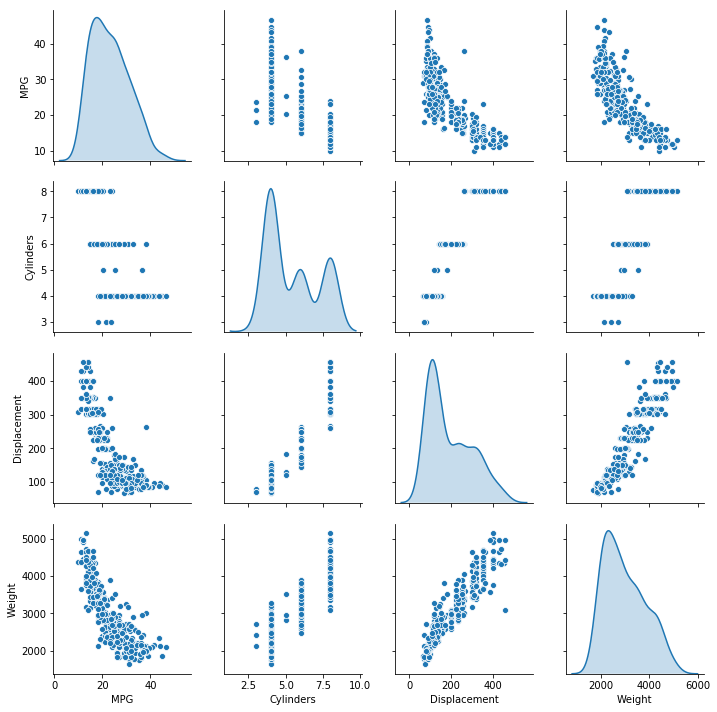

In [0]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

然后看一些数据的总体情况

需要注意的是，这些数据的范围很不同，对于机器学习而言，这不是一个好的情况，这也就是下面要做归一化的原因

In [0]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

####从特征中分离标签

将我们最终要学习的目标(target value or label) 从我们的各种特征中分离出来，作为我们模型训练用于预测的目标值

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

####数据归一化

虽然我们的模型在没有归一化的时候，也可能可以收敛，但是这样会让训练的过程非常的复杂，并且这会让我们的模型更依赖于输入类型的选择

注：虽然仅仅只是从训练集中去产生这些数据，这些统计数据也要用于归一化测试集，我们需要这样做来保证测试、训练集同分布

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

###模型训练

####搭建模型

我们搭建模型，一个输入层，一个隐藏层，一个输出层，输出层将返回一个单一的，连续值

我们用build_model来封装我们的构造过程，包括了层的搭建，模型的编译，等等会构造第二个模型

metrics是我们用于查看我们模型效果如何的评估指标

In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(units=64, input_shape=[len(train_dataset.keys())], activation=tf.nn.relu, name='input_layer'),
      layers.Dense(units=64, activation=tf.nn.relu, name='hidden_layer_1'),
      layers.Dense(units=1, name='output_layer')
  ])
  optimizer = keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mean_squared_error', # 可简写为mse
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error']) # 可简写为mae，mse
  return model

model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


####观察我们的模型

调用model.summary()可以看到我们模型的简单情况

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 64)                640       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


我们现在可以试试我们的模型，我们从训练集中去10个样本，然后直接用没有训练的模型进行预测

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.02492123],
       [-0.12408346],
       [-0.9954239 ],
       [-0.21057494],
       [-0.322498  ],
       [-0.1396345 ],
       [-0.35034633],
       [ 0.08496149],
       [-0.08946036],
       [-0.37101322]], dtype=float32)

从结果的形状和数据类型来看，是正确的，也就是说我们的模型是可以工作的

####训练我们的模型

我们将训练1000个epochs(周期)，每一个epochs都包括了我们所有的训练数据

由于这里的数据是pd.DataFrame类型，且输入训练集中不包括标签，因此这里fit的参数(x，y)都需要，即数据集和标签

我们将利用history对象来记录我们在训练和验证的过程中的模型的准确性

In [0]:
EPOCHS = 1000

class PrintProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if (epoch + 1) % 100 == 0:
      print('Epoch Finished {}/{}'.format(epoch + 1, EPOCHS))

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintProgress()]
)

Instructions for updating:
Use tf.cast instead.
Epoch Finished 100/1000
Epoch Finished 200/1000
Epoch Finished 300/1000
Epoch Finished 400/1000
Epoch Finished 500/1000
Epoch Finished 600/1000
Epoch Finished 700/1000
Epoch Finished 800/1000
Epoch Finished 900/1000
Epoch Finished 1000/1000


In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  mean_absolute_error  mean_squared_error  val_loss  \
995  3.094422             1.102383            3.094422  8.141957   
996  3.219910             1.128954            3.219910  8.321042   
997  3.255038             1.151291            3.255038  8.149830   
998  3.134383             1.096397            3.134383  8.657805   
999  3.198442             1.138161            3.198442  8.027985   

     val_mean_absolute_error  val_mean_squared_error  epoch  
995                 2.183829                8.141957    995  
996                 2.215626                8.321043    996  
997                 2.210663                8.149831    997  
998                 2.321924                8.657804    998  
999                 2.192092                8.027986    999

作图，观察训练过程中两个metric的变化过程

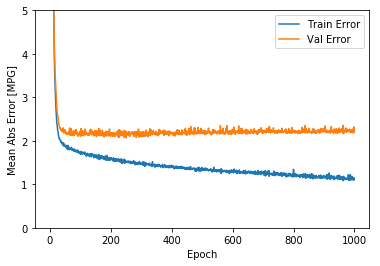

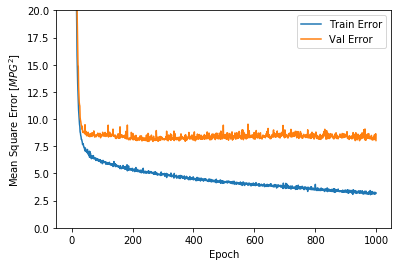

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label='Val Error')
  plt.ylim([0, 5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label='Val Error')
  plt.ylim([0, 20])
  plt.legend()
  plt.show()
  
plot_history(history)

可以看到的是，我们训练集和验证集的训练误差在逐渐增加，这不是一件好事，这说明我们的模型可能已经过拟合了

这里为了防止过拟合发生，我们可以选择一种很简单的方法，叫做early stopping

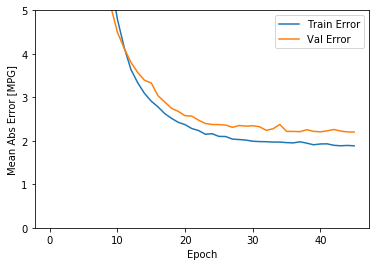

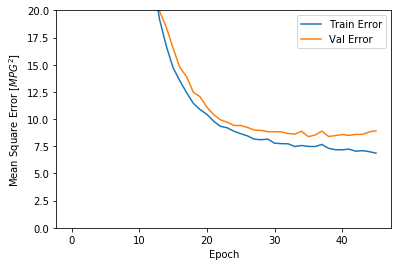

In [0]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # patience参数表示用于检测模型效果是否提升的epochs的数目，monitor通过哪个参数来监控

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintProgress()])

plot_history(history)

接下来我们看看模型在测试集上归一化的程度如何(效果)，我们可以从中推断出在实际应用中，我们的模型具体的效果如何

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print('Testing set Mean Abs Error: {:5.2f} MPG'.format(mae))

Testing set Mean Abs Error:  1.99 MPG


###用我们的模型预测

这里我们将用测试集中一系列的数据去预测MPG值

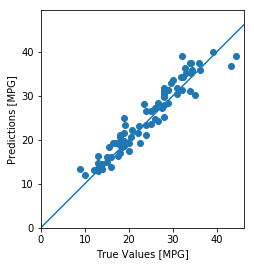

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

然后来看看误差分布

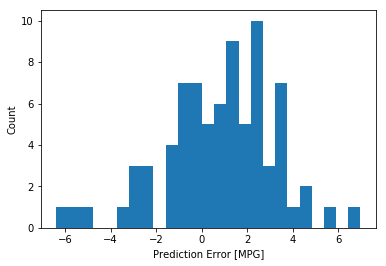

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

可以看到并不是很接近高斯分布，主要原因还是样本量太少了

###总结
1. 解决回归问题，MSE(均方误差)是常用的损失函数。同样的，常见的用于度量回归问题的指标是MAE(平均绝对误差)
2. 如果输入的数据特征的值分布在各自不同的范围中时，我们应当独立地将这些特征值归一化到相同的范围
3. 如果我们的训练样本不够大，最好选择隐藏层少的网络去避免过拟合的情况
4. 早期停止(Early stopping)是一个很好的用于防止过拟合的方法

##Fashion MNIST数据集及其简单的训练过程

这里我们可以选择GPU去对我们训练过程进行加速

###基本步骤

####安装tensorflow_datasets模块

安装tensorflow_datasets模块，该模块集成了Fashin MNIST数据集

In [0]:
!pip install -U tensorflow_datasets # -U or -u 表示update对于安装的模块进行升级

####导入依赖 (新库tqdm简单说明)

然后导入一些需要依赖的库，这里为了版本兼容性因此加入了__future__
如果确定版本为Python3则这句话可以不要

注：tqdm为一个快速的、可扩展的Python进度条，使用方便，只需要封装任意迭代器即可，即tqdm(iterator) (如range, list等)

In [0]:
from __future__ import absolute_import, division, print_function

# 导入Tensorflow及Tensorflow_Datasets并设置logging提示模式
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# 辅助库
import math
import numpy as np
import matplotlib.pyplot as plt

# 改进进度条显示(tqdm用于进度条配置)
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# 下面的这个命令将在2.0完整版的时候被移除，如果你运行的时候出错了，你的版本可能已经是2.0以上了，只需注释掉下面的即可
tf.enable_eager_execution()

####导入Fashion MNIST数据集

数据集中的图像是28×28的阵列，其灰度值的范围在 [0, 255]，标签是整数阵列，其范围是 [0, 9]，每一幅图像都映射了对应的某个标签，但是由于标签集没有在数据库中，因此我们要自己手动做一个，以便于后续的使用

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

#####浏览数据
我们在开始训练之前，先浏览一下我们的数据

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of train examples is {}".format(num_train_examples))
print("Number of test  examples is {}".format(num_test_examples))

Number of train examples is 60000
Number of test  examples is 10000


####数据预处理

由于数据集中每个像素范围为 [0, 255]，为了能让模型正常运作，我们需要归一化到 [0, 1]，因此需要进行预处理，并且将其应用在训练和测试数据集上

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# 通过调用map方法，可以将上面的归一化方法应用到训练和测试数据集中的每一个元素(样本)上面
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

#####浏览处理后的数据
让我们从里面去一个样本来画一下具体的形状


In [0]:
# 获取一组样本
for image, label in test_dataset.take(1):
  pass
# 去掉颜色维度
image = image.numpy().reshape((28,28))
# 绘制图像
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

让我们看一下25个训练集中的数据以及它们对应的标签名，确保数据的格式正确

In [0]:
plt.figure(figsize=(10,10))
i = 0
for image, label in train_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.yticks([]) # 去掉y轴坐标
  plt.xticks([]) # 去掉x轴坐标
  plt.grid(False) # 去掉网格
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

####构造模型
构造神经网络模型，我们需要配置相应的层，同时编译好我们的模型

#####搭建神经网络的每一层

层是神经网络中最基本你的模块，每一层都会从输入的数据中提取出相应的特征，而一系列层的搭建将能提取我们解决的问题的各种特征

许多深度学习网络通过很多简单的层连接在一起，大多数层，例如全连接层tf.keras.layers.Dense都有其内置的参数，这些参数将会在学习的过程中进行调整

In [0]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)]
)

该简单的神经网络由以下三层组成：

1. 输入层： tf.keras.layers.Flatten，这一层的功能是将一个图像从二维的阵列28×28转化为一维的阵列784(28*28)，你可以想象为将图像的每一行拼接起来，这一层没有学习的参数，只是重新格式化下数据
2. 隐藏层： tf.keras.layers.Dense，这一层是一个由128个神经元组成的全连接层，每一个神经元接受上一个层中784个神经元的输入，输出传入下一层，该层的权重和偏置将在训练的过程中学习
3. 输出层： tf.keras.layers.Dense，这是一个由10个节点构成的softmax层，每一个节点代表一个服装的类型，每个节点的权重将会被学习，然后输出一个在 [0, 1]的值，代表这幅图像属于该类的概率，总共10个节点的概率和应为1

#####编译神经网络
在模型训练之前，有一些参数还需要设置，这些参数将在编译过程中被设置，如：
1. Loss Function：损失函数
2. Optimzer： 优化器
3. Metrics： 度量指标，用于监控训练好测试步骤，这里我们用准确率来监控

In [0]:
model.compile(optimizer='adam', # 也可指定学习速率，如optimizer=tf.keras.optimizer.Adam(0.1)
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

####训练我们的模型
首先，我们要决定我们数据集的一些特性：
1. dataset.repeat()将会使数据集无限重复下去repeat(10)可以让数据集只重复10次(即使无限重复，epochs参数会限制我们训练的数量)
2. dataset.shuffle(60000)打乱了数据集的顺序，这使得模型能够从不同的顺序中进行学习
3. dataset.batch(32)告诉我们的模型，在使用model.fit的时候，一次训练一个batch(包括32个图像和标签)来更新模型的变量

训练是通过调用model.fit来完成的：
1. 使用train_dataset给予训练数据
2. 模型学习关联的图像和标签
3. epochs参数限制了数据训练的过程中，所有迭代的总次数，若为5，则表明我们共训练5次完整的训练样本，即5 * 60000 = 300000个样本

(注：其中的steps_per_epoch (每一个epoch中训练的步数，一步一个batch) 将会在新版本中被移除

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4936 - acc: 0.8260
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3748 - acc: 0.8655
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3403 - acc: 0.8770
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3117 - acc: 0.8857
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2918 - acc: 0.8932


我们可以看到每一个Epoch中，我们模型每一个Step的训练过程，其loss和对应的衡量标准(准确率)也很好地展示了出来，最后可以看到训练数据中模型的准确率约在0.88左右

####评估我们的模型
为了知道模型在测试集上面的准确性，这里我们需要在测试集中应用我们的模型继续评估

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples / BATCH_SIZE))
print('Loss     on test dataset: ', test_loss)
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 2s 8ms/step - loss: 0.3668 - acc: 0.8685
Loss     on test dataset:  0.3667602467413147
Accuracy on test dataset:  0.8685


####用模型去预测
当我们的模型训练好之后，我们就可以用我们的模型去对一些图像做相应的预测

虽然这里是take 1，但其实是take了一个batch，因此是32个样本，从后面的shape我们可以看到

In [0]:
for images, labels in test_dataset.take(1):
  test_images = images.numpy()
  test_labels = labels.numpy()
  predictions = model.predict(test_images)

In [0]:
predictions.shape

(32, 10)

我们来看看对第一个样本的预测结果

In [0]:
predictions[0]

array([7.2198995e-06, 2.0106510e-08, 1.9470078e-03, 2.0618052e-05,
       3.2853674e-02, 1.9099520e-09, 9.6517032e-01, 3.0314631e-09,
       1.0948216e-06, 9.8339514e-10], dtype=float32)

可以看到的是，predictions其实是一个长度为10的数组，其实就是对于10个种类的置信度，下面我们看看其中置信度最高的坐标是多少

In [0]:
np.argmax(predictions[0])

6

我们来看看和真值是否是相同的

In [0]:
test_labels[0]

6

  我们可以画图来查看具体这10个通道的情况


In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, image = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.yticks([])
  plt.xticks([])
  
  plt.imshow(image[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label is true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_labels):
  predictions_array, true_label = predictions_array[i], true_labels[i]
  plt.grid(False)
  plt.yticks([])
  plt.xticks([])
  thisplot = plt.bar(range(10), predictions_array, color='#777777') # 默认设置所有柱的颜色为灰色
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red') # 预测的柱为红色
  thisplot[true_label].set_color('blue') # 真值的柱为蓝色，若预测与真值相符，则最后只有一个蓝色柱

我们来看看第一幅图像的预测结果

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

然后我们来看看一些结果，红色为错误结果(即使置信度很高，也很有可能会出错)

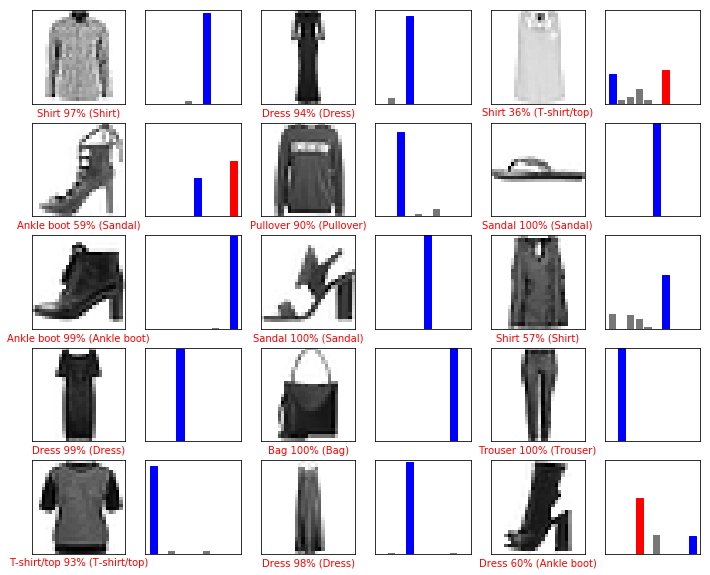

In [0]:
num_rows = 5 # 5行
num_cols = 3 # 3列
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

下面展示如何对一幅单一的图像进行预测

In [0]:
# 首先获取这幅图像
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [0]:
# 然后把它加入一个batch，这个batch只有它一个成员
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [0]:
# 然后进行预测(因为tf.keras是用于预测一个batch或整个collection的样本，因此即使我们只有一幅图像，也要化为标准的tf的batch的格式)
# 即NHWC
predictions_single = model.predict(img)
print(predictions_single)

[[7.2198995e-06 2.0106510e-08 1.9470097e-03 2.0618070e-05 3.2853723e-02
  1.9099520e-09 9.6517032e-01 3.0314631e-09 1.0948216e-06 9.8339514e-10]]


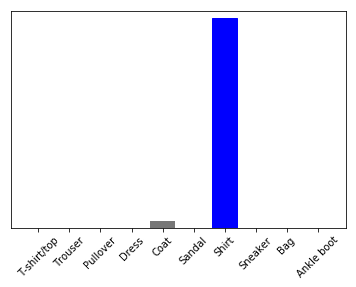

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

##卷积神经网络(CNN)

###简单概念

最常见的两个是：卷积(Convolution)以及池化(Pooling，最常用max-pooling)

以图像检测为例，无论一个目标在图像中的哪个部分(上方、下方或者边上)都无所谓，这个物体的识别结果都是不变的。用卷积神经网络来硬编码这种位置不变性，因此网络具有结构重复性，从而能够确保在图片某个角落学到的规律也起作用。

所谓卷积，即应用一个过滤器(卷积核)去处理一幅图像，而最大池化则是通过下采样来缩减图像的大小



####依赖的安装以及库的引入

类似于前面简单的Fashion MNIST数据集的训练过程，需要相关的库

In [0]:
!pip install -U tensorflow_datasets

    100% |████████████████████████████████| 409kB 27.0MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# 引入Tensorflow库以及Tensorflow_dataset库
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# 引入一些辅助库
import math
import numpy as np
import matplotlib.pyplot as plt

# 优化Python的进度条显示进程
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# 同前面，该方法将会在2.0被移除，如果报错，并且版本为2.0以上，则可以注释掉下面这句
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


###引入Fashion MNIST数据集

tfds.load的[API具体在此](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)，简单说下几个参数含义：

1. name：即第一个参数，表示数据集的名字，可以通过list_builders()查看已有的
2. split：该参数应该设置为tfds.Split或者是string类型(tfds.Split.TRAIN 或者 'train')，用于选择读取的数据的分类模型(一般是训练或者测试)，如果没有设置该参数，则会以dict形式返回所有的被分割的数据(一般是tfds.Split.TRAIN和tfds.Split.TEST)通过返回的dataset['train']/['test']即可获取
3. as_supervised：bool类型变量，如果为True，则会返回tf.data.Dataset类型变量，该变量有2元元祖的结构(input, label)，如果为False，则该返回的类型变量将有与特征相关的dict
4. with_info：如果为True，则多返回一个tfds.core.DatasetInfo变量

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

构造标签与类名的映射关系

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

####预览数据

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


###预处理数据

数据需要归一化

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

####预览归一化的数据

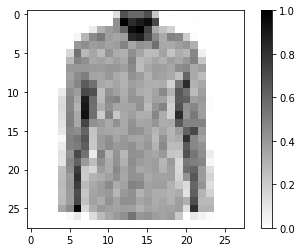

In [0]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

预览25幅来自训练集的图像，并且显示其类名

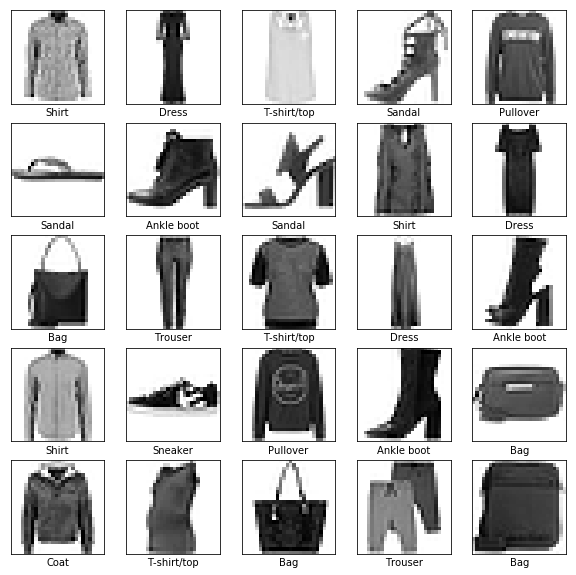

In [0]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

###搭建模型

模型的搭建总共包括下面几个步骤：1. 配置每层的参数，2. 编译模型

####设置每一层的参数

机器学习中，每一层都会根据输入的数据提取出其与问题相关有意义的特征

在训练(学习)的过程中，这些曾的内部参数都会不断地进行修正

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu,
                          input_shape=(28,28,1), name='Convolution_layer_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, name='Pooling_layer_1'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name='Convolution_layer_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, name='Pooling_layer_2'),
    tf.keras.layers.Flatten(name='Flatten_layer'),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu, name='Dense_layer_1'),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu, name='Dense_layer_2'),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name='Output_layer')
])

可以看到我们模型总共设置了5层(两个卷积池化层，三个全连接层)

####编译模型

设置相应的Loss Function，Optimizer， Metrics

然后查看我们模型的简单信息

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution_layer_1 (Conv2D) (None, 28, 28, 32)        320       
_________________________________________________________________
Pooling_layer_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
Convolution_layer_2 (Conv2D) (None, 14, 14, 64)        18496     
_________________________________________________________________
Pooling_layer_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 3136)              0         
_________________________________________________________________
Dense_layer_1 (Dense)        (None, 512)               1606144   
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 128)               65664     
__________

###训练我们的模型

首先，要定义训练集的一些特征，主要包括：
1. Repeat()：让训练集一直重复，通过epochs限制训练次数
2. shuffle()：然训练集中的数据随机打乱
3. batch()：决定一次训练一个batch用多少个样本

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(60000).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

然后通过model.fit方法去配置我们具体的训练过程，可以通过获取返回的参数(history)来具体查看训练的过程

In [0]:
model.fit(train_dataset, epochs=10, verbose=1, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3813 - acc: 0.8601
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2406 - acc: 0.9109
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1965 - acc: 0.9267
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1650 - acc: 0.9378
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1347 - acc: 0.9513
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1091 - acc: 0.9597
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0913 - acc: 0.9669
Epoch 8/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0759 - acc: 0.9715
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0628 - acc: 0.9762
Epoch 10/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0522 - acc: 0.9812


可以看到模型训练过程中损失函数值和度量标准(准确率的变化过程)，最终模型的准确率达到了98%

###评估我们的模型

接下来我们调用evaluate来评估我们的模型效果，我们将采用测试集作为评估标准

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples / BATCH_SIZE))
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3776 - acc: 0.9205
Accuracy on test dataset:  0.9205


可以看到，在测试集上面，我们的模型没有训练集表现得好，这是因为测试集的数据都是未曾见到过的数据，因此会出现准确率下降的情况

###用我们的模型进行预测

有了模型之后，我们可以根据图像进行预测

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [0]:
predictions.shape

(32, 10)

predictions包含了一个BATCH里面所有的预测结果，我们先看第一个

In [0]:
predictions[0]

array([1.9788973e-09, 7.6377064e-12, 1.9284806e-07, 3.3466534e-09,
       1.9209897e-03, 2.4216977e-09, 9.9807882e-01, 7.1501756e-13,
       1.2442071e-10, 1.8676301e-10], dtype=float32)

In [0]:
np.argmax(predictions[0])

6

In [0]:
test_labels[0]

6

然后重复之前的过程，我们进行画图，查看结果

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

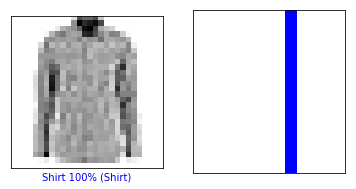

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

我们画前15幅图像的预测结果，蓝色代表正确的真值，红色代表错误的预测结果

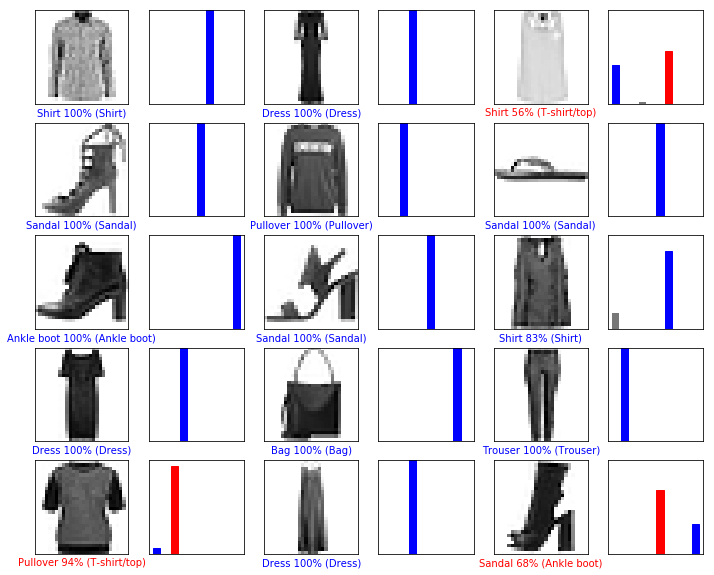

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## 卷积神经网络(CNN)深入学习

过拟合与欠拟合：
    过拟合也叫做bias-variance trade-off(偏差-方差权衡)
    如果网络中权重太少，导致网络不能够很好地学习足够的组分，如果网络中需要学习的元素过多，这样网络可能会选择一种并不满足你预期的解决方法

### 猫狗(Cats&Dogs)分类CNN简介

我们将使用微软的图像数据集中的猫狗图像，数据集中每个图像都被标注为1或0(1代表狗狗，0代表猫咪)，虽然微软的(猫狗)数据集很庞大(300万，但只有25000是公开的数据)，使用25000幅图像训练网络将耗费很长时间，因此这里选用其中的子集作为训练的数据集(2000幅训练集(1000个狗狗，1000个猫咪)，1000幅验证集)

这个部分我们将遇到两个问题：
1. 图像尺寸不同
2. 图像为彩色图像

#### 图像的尺度问题

问题的原因是神经网络通常需要一个固定大小的输入，以Fashion MNIST数据集为例，所欲图像均为(28,28,1)的，因此网络的Input_shape为(28,28,1)，然而当输入的图像尺寸不同的时候，将输入图像扁平化操作会导致得到的一维数组的大小也是变化的

由于网络需要固定大小的输入，仅仅扁平化操作将不起作用。因此在做图像分类的时候，我们常常需要对输入图像改变大小(resize)到同样的尺度才行(这样会导致图像变形等问题)，不过这里我们先采用这个操作，将图像都缩放到150×150的形状

#### 彩色图像问题

彩色图像相比于灰度图像在第三个维度上更多，大多数图像都可以有对应的RGB颜色通道来表示，多通道合在一起可以表示一幅图像

既然我们的图像是多通道的，我们就需要修改我们之前的代码

In [0]:
# import tensorflow.keras as keras
# import tensorflow.keras.layers as layers

model = keras.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28,28,1)))

之前的代码中，input_shape是根据Fashion MNIST中数据的具体的长、宽获取的(这个数据集中，图像均为28像素高，28像素宽)，第三个为颜色通道的数目，由于是灰度图像，因此为1

In [0]:
model = keras.Sequential()
model.add(layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)))

##### 彩色图像的卷积操作

因为我们图像为RGB图像，且均将resize到150×150的图像，因此，我们的输入形状为(150,150,3)，因为我们要去处理RGB图像，我们的filter的维度也将变为3维，RGB每个通道都将有自己对应的filter，对于每个通道，每个filter进行卷积操作后，将对应区域数据相加(再加上权重)就会得到我们最终的该filter下的卷积结果(为2维的，形状与原图一样(采用padding='same'))，该结果为在该filter下提取的特征

通常情况下，我们一层卷积层会采用多个filter，我们将得到多个不同的卷积输出，因此输出的结果形状将为(150,150,filter_nums) - filter的数目将由Conv2D的第一个参数(filters决定，上面为16)

我们也能通过第二个参数kernel_size决定filter的形状(3×3或者5×5或等等)，这些参数就是在学习过程中会更新的，以最小化损失函数

In [0]:
tf.keras.layers.Conv2D(3, (3,3), ...) # 我们将创建一个卷积核为3×3，共3个filters的卷积层

##### 彩色图像的池化操作

max_pooling的作用是一样的，关键在于如何对每一个卷积的输出进行max_pooling操作，实际上，就是对每一个卷积的输出结果(即每个filter提取的特征)进行max_pooling操作，因此特征数不变(same_depth)，只是特征的数据大小发生变化(width & height)

### 猫狗分类CNN搭建

#### 相关库的引入

引入几个后面会用到的库
1. os - 用于读取文件以及目录结构
2. numpy - 用于处理Tensorflow外的一些矩阵的数学运算
3. matplotlib.pyplot - 用于画图以及展示训练集和测试集的图像

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import numpy as np

引入Tensorflow，我们可以直接指定Keras中的一些代号(例如Sequential, Dense等)，这样可以让我们在代码中直接去用他们的名字而不是使用全部的名称(例如，我们可以用Dense 替代 tf.keras.layers.Dense)

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.logging.set_verbosity(tf.logging.ERROR)

#### 数据读取

为了能够构造我们的图像分类器，我们首先要下载数据集，我们将使用Kaggle(最终是由Microsoft提供的)修正后的[Dogs vs. Cat](https://www.kaggle.com/c/dogs-vs-cats/data)数据集版本

在之前的学习中，我们都用的是Tensorflow的Dataset(简单且好用)，但是在这里，我们将使用tf.keras.preprocessing.image.ImageDataGenerator类去读取硬盘中的数据，因此我们将直接下载Dogs vs. Cat数据集并且将它解压到Colab的文件系统中

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' # 数据集的URL
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True) # 获取URL的文件，同时解压

68608000/68606236 [==============================] - 1s 0us/step


我们下载的数据集将有以下的目录结构 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

我们可以通过下面的终端命令来列出该目录

In [0]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


然后我们可以分配特定的训练集和验证集的目录变量

In [0]:
base_dir = os.path.join(zip_dir_base, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # 训练集中的猫咪图片
train_dogs_dir = os.path.join(train_dir, 'dogs') # 训练集中的狗狗图片
validation_cats_dir = os.path.join(validation_dir, 'cats') # 验证集中的猫咪图片
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 验证集中的狗狗图片

#### 观察我们的数据

让我们看看我们的训练集和测试集都有多少的猫猫狗狗图片

In [0]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [0]:
print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### 设置我们模型的参数

为了方便，我们将设置一些会用于数据预处理过程以及网络训练的变量

In [0]:
BATCH_SIZE = 100 # 我们训练过程中一个BATCH包括的图片数目，每次用这么多图片去训练然后更新一次我们的模型的变量
IMG_SHAPE = 150 # 我们的图像将会resize到150×150

#### 数据准备

我们的图像必须在流入到网络之前被准确地格式化为合适的预处理浮点张量，这一步骤包括下面的内容：
1. 从硬盘读取数据
2. 解码图片内容，并根据其RGB的内容转化为正确的网格格式
3. 将上面的转化为浮点张量(floating point tensor)
4. 将张量的0~255的值归一化到0~1，因为神经网络在处理小的输入的情况下效果更好

而上面的这些步骤，都可以由tf.keras.preprocessing.image.ImageDataGenerator来完成

通过下面几行代码就可以完成设置

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 训练集的Generator
validation_image_generator = ImageDataGenerator(rescale=1./255) # 测试集的Generator

构造好ImageDataGenerator后，我们可以调用flow_from_directory方法将我们的图像从硬盘中读出，然后rescale & resize

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE), # (150, 150)
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              shuffle=False, # 验证集不需要进行shuffle 
                                                              target_size=(IMG_SHAPE, IMG_SHAPE), # (150, 150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 训练数据(图像)可视化

我们可以通过上面的生成器获取一个batch的图像，然后进行可视化

In [0]:
sample_training_images, _ = next(train_data_gen)

next方法将会返回一个batch的数据，其类型为tuple-(many images, many labels)，不过我们现在不关心labels，我们现在只关心图像

In [0]:
# 这个方法将会在一个1行5列的方框中画出图像
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

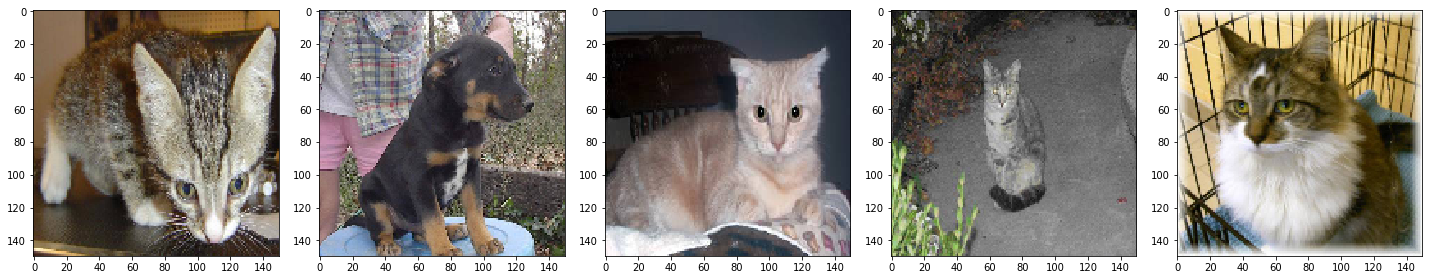

In [0]:
plotImages(sample_training_images[:5])

#### 模型构造

##### 定义模型(Sigmod & Softmax)

我们的模型包括了每个部分的卷积单元以及池化单元，最后有一个512个神经元的全连接层(relu激活)，最后用softmax输出两种类的预测概率

可以看到我们没有采用zero-padding，因此第一层输出的shape并非150×150，而是148×148

我们最后是通过softmax分类器进行分类的，因此最后一层的units为2，当然，我们还有另外一种用于两类分类的分类器Sigmoid，如果激活函数为sigmoid，不过这样的话，units只用1个即可，但是，**值得注意的是**，如果你决定了要用sigmoid作为分类激活函数，你就需要将损失函数由sparse_categorical_crossentropy改变为binary_crossentropy

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3), name='input_layer'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='input_maxpooling'),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='conv_layer_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_layer_2'),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='conv_layer_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_layer_3'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu', name='fc_layer'),
    tf.keras.layers.Dense(units=2, activation='softmax', name='output_layer')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 148, 148, 32)      896       
_________________________________________________________________
input_maxpooling (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 72, 72, 64)        18496     
_________________________________________________________________
pooling_layer_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv_layer_3 (Conv2D)        (None, 34, 34, 64)        36928     
_________________________________________________________________
pooling_layer_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
__________

#### 编译模型

一样，我们采用Adam优化器，由于我们的输出是softmax分类，因此我们采用sparse_categorical_crossentropy作为损失函数，为了观测准确率的变化，我们传递了accuracy作为评估标准

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#### 训练模型(fit_generator)

现在开始训练模型，由于我们的数据是由ImageDataGenerator产生，因此我们要用fit_generator而不是用fit来训练了

In [0]:
EPOCHS = 100
history = model.fit_generator(train_data_gen, 
                              steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), 
                              epochs=EPOCHS, 
                              validation_data=val_data_gen, 
                              validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
                             )

Epoch 1/100
20/20 [==============================] - 12s 594ms/step - loss: 1.0413 - acc: 0.4920 - val_loss: 0.6901 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - 7s 361ms/step - loss: 0.6853 - acc: 0.5555 - val_loss: 0.6731 - val_acc: 0.6320
Epoch 3/100
20/20 [==============================] - 7s 366ms/step - loss: 0.6634 - acc: 0.5940 - val_loss: 0.6625 - val_acc: 0.5370
Epoch 4/100
20/20 [==============================] - 8s 394ms/step - loss: 0.6283 - acc: 0.6475 - val_loss: 0.5920 - val_acc: 0.6910
Epoch 5/100
20/20 [==============================] - 8s 375ms/step - loss: 0.5947 - acc: 0.6830 - val_loss: 0.6109 - val_acc: 0.6510
Epoch 6/100
20/20 [==============================] - 8s 417ms/step - loss: 0.5805 - acc: 0.6970 - val_loss: 0.5998 - val_acc: 0.6740
Epoch 7/100
20/20 [==============================] - 8s 384ms/step - loss: 0.5226 - acc: 0.7410 - val_loss: 0.5771 - val_acc: 0.7030
Epoch 8/100
20/20 [==============================] - 7s 356ms/step -

#### 训练结果可视化

我们现在来看看我们网络的训练情况

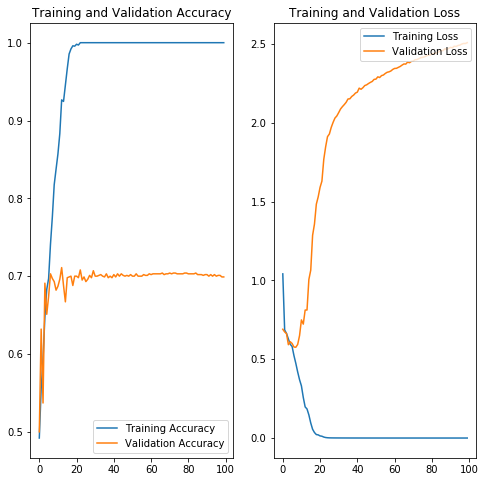

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

我们可以看到，在训练的过程中，训练的准确性和验证集的准确性直接差别很大，我们的模型在验证集上只有70%的精确度(取决于Epoch的数)

这表明我们的模型已经过拟合了(验证集的loss在不断上升)，一旦我们的训练曲线和验证曲线开始分离，这就说明我们的模型在记忆我们的训练数据，但是并不能很好地在验证集上有优异表现

因此，后面要涉及到如何防止过拟合(又可以叫做记忆训练集)的发生

### 图像分类训练过拟合处理策略

#### 一、图像扩增(Image Augmentation)策略

我们在处理物体识别的时候，我们希望我们的网络不管图像的大小或者物体的位置：不管物体是处于图像的中心，或者是图像的边缘，无论物体是整个都在或者是只有部分在图像中，无论物体是该类的子类(例如某种品种的狗狗)我们的网络都要有能力去识别出来。因此，理想的情况下，我们的网络在训练的过程中，应该对于上述的情况都有训练到。当我们数据集足够庞大的时候，我们的网络将可能会有更好的性能以及更低的过拟合可能性

当然，我们的网络常常很容易只有很少的样本，这就会导致我们的网络过拟合的情况容易发生。对于数据集扩增，我们可以用一个方法叫做Image Augmentation

Image Augmentation通过对于原始图像采用一些随机的图像变换策略从而获得扩增的数据集。例如，我们可以对原始图像进行旋转(rotation)，翻转(flipping)，尺度变换(zoom)等等

#### 二、Dropout策略

Dropout也是一种可以减少过拟合的策略

我们的网络在训练过程中，可能会出现某个层中的一些神经元的权重非常大，而其他的一些神经元的权重非常小，因此这些有大权重的神经元在训练的过程中就会扮演主导角色，而小权重的则表现较差(很难得到足够的训练)。因此，dropout是避免这种情况的策略之一，dropout可以在训练的过程中，随机地关闭一些神经元(不起作用，在前向传播和反向优化的过程中均不参与)。采用这种策略之后，我们可以发现我们的网络稳定，因为它并不是完全依赖所有的神经元去解决这个问题。

#### 三、Early Stopping策略

该方法在之前的训练中有提到，通过对验证集性能在一定的epochs中是否提升从而决定是否停止模型训练过程

### 优化(减轻过拟合)的猫狗分类网络

采用图像扩增的方法减少过拟合(Image Augmentation)

前面库的引入，以及数据集的下载与之前的部分相同

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True) # 返回下载的.zip文件的路径(包括zip文件名)

In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # 猫猫训练集路径
train_dogs_dir = os.path.join(train_dir, 'dogs')  # 狗狗训练集路径
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 猫猫验证集路径
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 狗狗验证集路径

In [0]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("一")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
一
Total training images: 2000
Total validation images: 1000


In [0]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # 训练图像尺寸将会在150×150

#### 数据扩增具体方法


过拟合往往由于数据集不够庞大导致，我们采用Image Augmentation方法从已有的数据集中通过对样本进行随机变换从而产生可信的图像数据，这样的目的是为了让我们的网络在训练的过程中，不会两次去看到完全相同的图像(希望)，这让我们的网络归纳(generalize)的能力更好

我们通过tf.keras的ImageDataGenerator传递变换方法，让我们的网络在训练过程中对于训练图像进行变换

首先我们先定义一个查看图像的方法

In [0]:
def plotImages(images_arr):
    images_num = len(images_arr)
    fig, axes = plt.subplots(1, images_num, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

##### 水平翻转图像

我们通过将ImageDataGenerator类的horizontal_flip参数设置为True，可以对我们的图像随机应用翻转

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


为了能够见到变换效果，我们获取训练集中的一个样本五次，在每一次重复获取的时候，我们的数据会随机地应用这个方法(可能用可能不用)

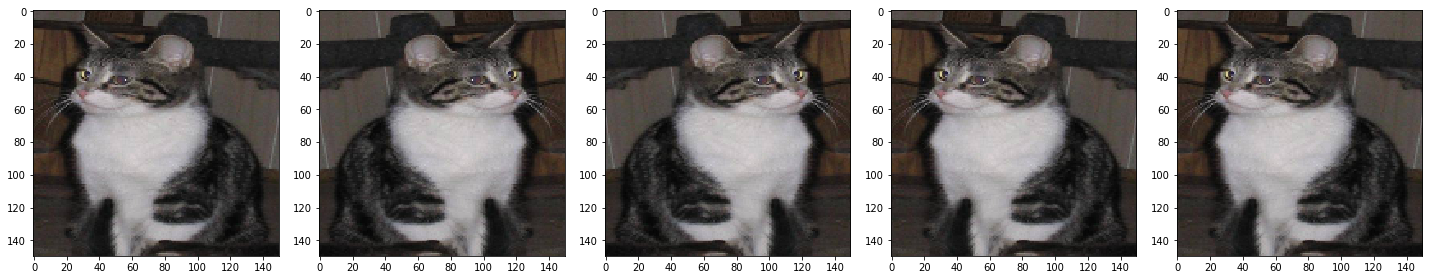

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### 图像旋转

同样的，我们设置rotation_range旋转角度范围可以对图像进行旋转

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


然后观察效果

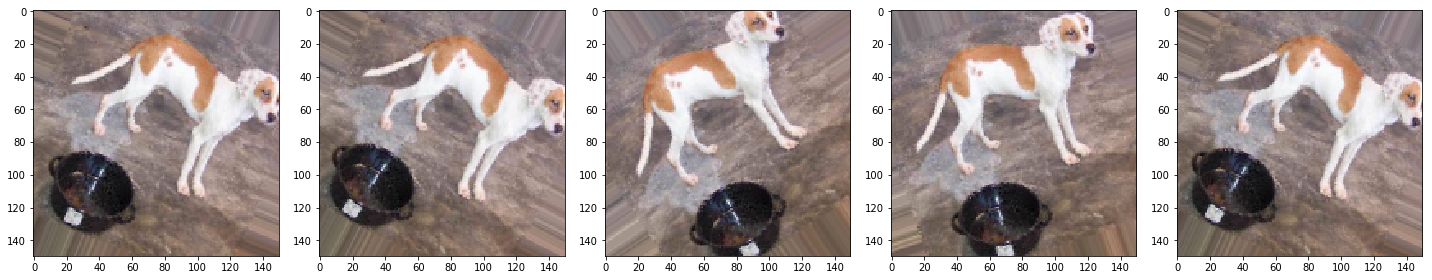

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### 图像尺度变换

这里我们设置zoom_range参数来决定变换范围

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


然后观察效果

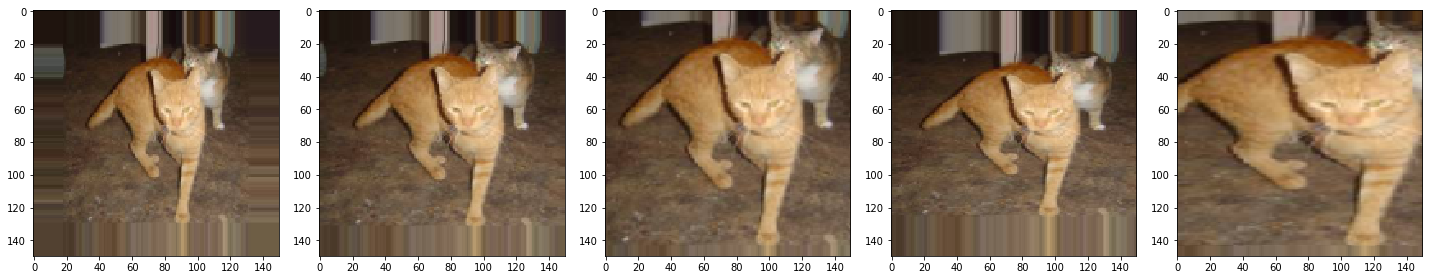

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### 各种变换效果混合使用

我们这里采用多种变换方法，例如：rescale、45度范围旋转、宽度移动、高度移动、水平翻转、图像缩放(shear zoom)应用

这些方法对于的参数分别为：rescale, rotation_range, width_shift_range, height_shift_range, horizontal_flip, shear_range, zoom_range

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') # 边缘填充模式

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


然后我们继续查看效果

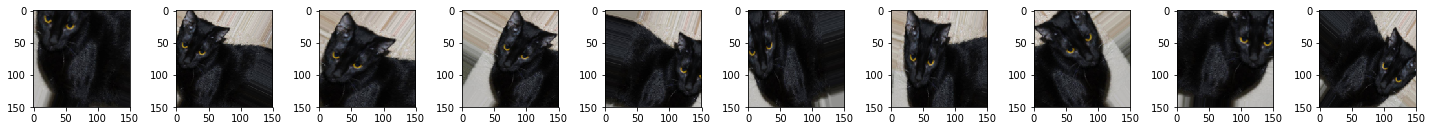

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(10)]
plotImages(augmented_images)

#### 验证数据集

我们不需要对于验证集的进行变换

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=validation_dir, 
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### 构造模型

我们的模型依然包括4个卷积层和池化层

但是在最后的扁平化操作之前，我们先对输出进行Dropout，我们这里设置为0.5，意味着我们50%的前面的卷积输出将会被设置为0，这可以有利于阻止过拟合

最后采用全连接层(relu激活)以及softmax分类层来实现物体分类

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    tf.keras.layers.Dropout(rate=1-0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)       147584    
__________

#### 模型编译

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 模型训练

下面我们将在100个Epochs中对我们的模型进行训练

In [0]:
epochs = 100
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))))

Epoch 1/100
20/20 [==============================] - 18s 909ms/step - loss: 0.7392 - acc: 0.4920 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - 17s 825ms/step - loss: 0.6922 - acc: 0.5040 - val_loss: 0.6888 - val_acc: 0.6290
Epoch 3/100
20/20 [==============================] - 15s 752ms/step - loss: 0.6849 - acc: 0.5470 - val_loss: 0.6433 - val_acc: 0.6330
Epoch 4/100
20/20 [==============================] - 15s 769ms/step - loss: 0.6710 - acc: 0.5750 - val_loss: 0.6383 - val_acc: 0.6320
Epoch 5/100
20/20 [==============================] - 16s 790ms/step - loss: 0.6427 - acc: 0.6200 - val_loss: 0.6425 - val_acc: 0.6380
Epoch 6/100
20/20 [==============================] - 16s 785ms/step - loss: 0.6557 - acc: 0.6230 - val_loss: 0.6068 - val_acc: 0.6550
Epoch 7/100
20/20 [==============================] - 15s 759ms/step - loss: 0.6134 - acc: 0.6670 - val_loss: 0.5698 - val_acc: 0.7010
Epoch 8/100
20/20 [==============================] - 15s 751ms

#### 模型结果可视化

训练完成后，我们再看一看模型训练结果

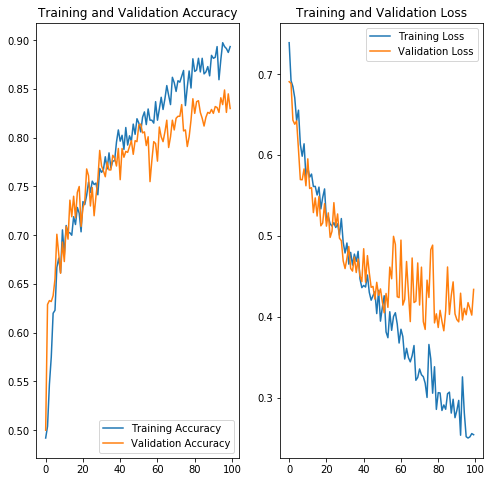

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 ### 用于花分类的CNN (exercise)

#### 相关库引入

我们这里需要用到：
1. os用于文件路径的读取
2. glob用于路径下文件的获取(获取符合条件的文件路径)
3. numpy用于将python的list转变为numpy的ndarray类，并且进行需要的矩阵操作
4. matplotlib.pyplot用于显示训练集和测试集的图像
5. shutil用于copy文件

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals

import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import shutil

Tensorflow相关模块的引入

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 数据下载与读取

首先我们需要下载花的数据库并把它放在/tmp目录下面

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_dir = keras.utils.get_file(fname='flower_photos.tgz',
                               origin=_URL,
                               extract=True)

base_dir = os.path.join(os.path.dirname(zip_dir), 'flower_photos') # dirname与basename分别对应split方法分割path的第一个元素与第二个元素

228818944/228813984 [==============================] - 1s 0us/step


这个数据集包括五种类型的花，Rose, Daisy, Dandelion, Sunflowers, Tulips，因此，我们要先建立类对应关系

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

在下载解压完成之后，数据库将有以下的数据结构
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

但是这里并没有训练集和验证集的数据库，我们需要的是类似于下面的文件结构

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]   
</pre>

因此我们要自己创建新的目录，然后随机将数据进行分类，并放在对应的目录中，我们的分类界限为80%的训练集以及20%的测试集

参考方法一

In [0]:
for cl in classes:
  cl_dir = os.path.join(base_dir, cl)
  cl_imgs = []
  for img_filename in glob.glob(os.path.join(cl_dir, '*.jpg')):
    cl_imgs.append(img_filename)
  random.shuffle(cl_imgs)
  cl_tr_imgs = cl_imgs[:int(math.ceil(len(cl_imgs) * 0.8))]
  cl_val_imgs = list(set(cl_imgs).difference(set(cl_tr_imgs)))
  print("{}: {} Images \n {} used for train, {} used for validation".format(cl, len(cl_imgs), len(cl_tr_imgs), len(cl_val_imgs)))
  cl_tr_dir = os.path.join(base_dir, 'train', cl)
  cl_val_dir = os.path.join(base_dir, 'val', cl)
  if not os.path.exists(cl_tr_dir):
    os.makedirs(cl_tr_dir)
    for tr_img in cl_tr_imgs:
      shutil.move(tr_img, cl_tr_dir)
  if not os.path.exists(cl_val_dir):
    os.makedirs(cl_val_dir)
    for val_img in cl_val_imgs:
      shutil.move(val_img, cl_val_dir)


roses: 641 Images 
 513 used for train, 128 used for validation
daisy: 633 Images 
 507 used for train, 126 used for validation
dandelion: 898 Images 
 719 used for train, 179 used for validation
sunflowers: 699 Images 
 560 used for train, 139 used for validation
tulips: 799 Images 
 640 used for train, 159 used for validation


参考方法二

官方答案，与一基本相同

In [0]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


当然这里有很多获取的方法，例如可以用os.walk去获取根目录，子目录，文件名

可以用listdir获取目录下的子目录和文件名用os.path.isfile去排除其中的文件

等等这些都是可以选择的方法

方便起见，我们设置训练集和验证集的目录变量

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

可以简单看一下这些目录包含的内容

In [0]:
!ls -a $base_dir
!ls -a $train_dir
!ls -a $val_dir

.  ..  daisy  dandelion  LICENSE.txt  roses  sunflowers  train	tulips	val
.  ..  daisy  dandelion  roses	sunflowers  tulips
.  ..  daisy  dandelion  roses	sunflowers  tulips


#### 数据扩增操作(Image Augmentation)

其实我们的数据库的数据量并不够庞大，因此容易出现过拟合的情况，因此这里需要用到tf.keras的ImageDataGenerator类的数据扩增方法，因此我们前面引入了该类

我们首先设置batch的大小，以及图像需要归一的大小范围

In [0]:
BATCH_SIZE = 64
IMG_SHAPE = 150

image_gen_train = ImageDataGenerator(rescale=1./255,
                               rotation_range=45,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

##### 训练集的Generator操作

In [0]:
train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     class_mode='sparse',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True)

Found 2939 images belonging to 5 classes.


然后预览一幅图片观察效果，首先我们定义图像阵列预览方法

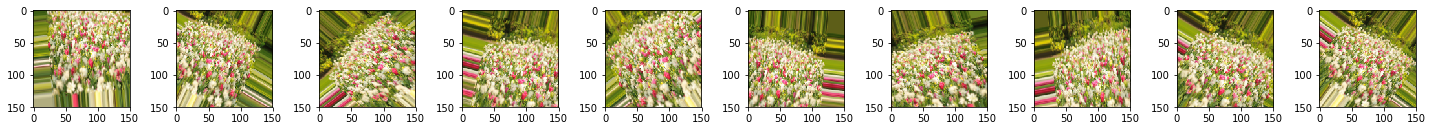

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(10)]
plotImages(augmented_images)

##### 验证集的Generator操作

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse',
                                                 batch_size=BATCH_SIZE)

Found 731 images belonging to 5 classes.


#### 搭建CNN网络

第一种模型：
1. 4层卷积层(32, 32, 64, 64)及最大值池化层
2. 一层dropout(rate 0.5)及全连接和softmax层

In [0]:
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    layers.Dropout(rate=1-0.5),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=5, activation='softmax')
])

第二种模型：(官方模型)
1. 三层卷积层(16, 32, 64, same-padding)及最大值池化
2. 两个dropout(rate 均为0.2)及全连接和softmax层

In [0]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

#### 模型编译

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

模型观察

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        36928     
__________

#### 模型训练

不像之前，我们有训练集的各个种类的各个数目，这里我们直接用train_data_gen的n获取数目

然后像之前一样，开始我们的模型训练

In [0]:
EPOCHS = 60

history = model.fit_generator(generator=train_data_gen,
                              steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))))

Epoch 1/60
46/46 [==============================] - 25s 542ms/step - loss: 1.3199 - acc: 0.4202 - val_loss: 1.2731 - val_acc: 0.4856
Epoch 2/60
46/46 [==============================] - 21s 466ms/step - loss: 1.1228 - acc: 0.5339 - val_loss: 1.0535 - val_acc: 0.5677
Epoch 3/60
46/46 [==============================] - 21s 450ms/step - loss: 1.0244 - acc: 0.5829 - val_loss: 1.0477 - val_acc: 0.5855
Epoch 4/60
46/46 [==============================] - 22s 472ms/step - loss: 0.9676 - acc: 0.6091 - val_loss: 0.9741 - val_acc: 0.6211
Epoch 5/60
46/46 [==============================] - 21s 458ms/step - loss: 0.9404 - acc: 0.6278 - val_loss: 0.9756 - val_acc: 0.6129
Epoch 6/60
46/46 [==============================] - 21s 448ms/step - loss: 0.9045 - acc: 0.6434 - val_loss: 1.0534 - val_acc: 0.6129
Epoch 7/60
46/46 [==============================] - 21s 466ms/step - loss: 0.8724 - acc: 0.6550 - val_loss: 0.8693 - val_acc: 0.6744
Epoch 8/60
46/46 [==============================] - 22s 482ms/step - 

#### 训练结果查看

查看训练过程的准确率和损失函数的变化过程，看看有没有过拟合

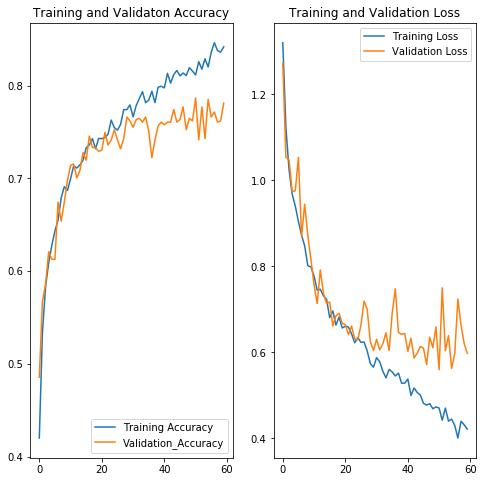

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validaton Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

用我们的模型进行一下图像预测

In [0]:
val_images = np.array([val_data_gen[0][0][i] for i in range(10)])
predictions = model.predict(val_images)
print(predictions)

[[2.11964641e-02 9.44367409e-01 1.69549398e-02 3.70573136e-04
  1.71105452e-02]
 [2.23306421e-12 7.41696294e-06 4.74119588e-08 9.99992371e-01
  1.82976621e-07]
 [9.57838260e-04 2.58861110e-02 2.10605394e-02 8.43999326e-01
  1.08096212e-01]
 [2.99864005e-05 3.59729253e-04 8.40161738e-06 9.99528766e-01
  7.30740212e-05]
 [4.98966237e-08 9.48261142e-01 1.31449426e-07 5.08279838e-02
  9.10830277e-04]
 [9.83777881e-01 9.52448056e-04 9.54221934e-04 6.58298493e-04
  1.36572104e-02]
 [6.00371353e-09 7.36623497e-06 5.22061600e-05 9.99837518e-01
  1.02895814e-04]
 [3.59496754e-03 9.94125724e-01 3.09181865e-04 6.48148343e-05
  1.90532755e-03]
 [1.03196749e-06 1.10849360e-05 1.00986632e-02 1.97782973e-03
  9.87911463e-01]
 [9.98544812e-01 8.03855481e-04 3.02085013e-04 3.27568501e-04
  2.16684020e-05]]


In [0]:
predicted_label = np.argmax(predictions[0])
print(predicted_label)
print(val_data_gen.class_indices)

1
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## 迁移学习

迁移学习是指利用现有的模型，并根据新的应用场景稍加修改，迁移学习能让我们不用从头训练模型，大大提升性能

前面部分，我们训练了一个CNN-Image-Classifier(CNN图像分类器)并且还有过拟合的情况发生，并且验证集的识别率在70%左右，后面通过数据增强以及Dropout显著降低了过拟合并且让识别率上升到80%

这里将使用迁移学习来提升我们的识别率，我们会用已经被大量数据预训练的模型去训练

为了进行迁移学习，我们修改预训练模型的最后一个层级(分类输出层)，因为不同的数据集有不同数量的输出类别(例如：ImageNet有1000种，Fashion-MNIST有10种，Cats&Dogs有2种)，并且确保训练过程中不修改模型的预训练部分(方法就是在训练的过程中将预训练模型的变量设置为不可训练，即冻结模型)冻结之后只有最后的分类层级的变量会接受训练。如果不冻结预训练变量的话，新的分类层级没有接受过训练(比如我们采用随机初始化权重)，这样就会在反向传播过程中使得预训练的变量错误地更新，导致模型变差



### 相关库引入

这里要用到tf-nightly-gpu，tensorflow_hub(用于加载迁移用的预训练模型，我们将用这里的模型进行迁移学习)，tensorflow_datasets

In [0]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 377.6MB 59kB/s 
     |████████████████████████████████| 3.1MB 29.4MB/s 
     |████████████████████████████████| 61kB 21.6MB/s 
     |████████████████████████████████| 491kB 40.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
     |████████████████████████████████| 686kB 2.8MB/s 


然后进行往常的Import

In [0]:
from __future__ import absolute_import, print_function, division, unicode_literals

import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

### 第一部分

这部分里面我们将使用Tensorflow Hub 的 MobileNet用于检测

In [0]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

使用一幅图进行模型检测

65536/61306 [================================] - 0s 0us/step


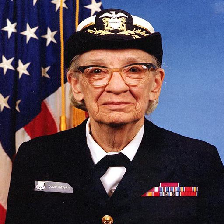

In [0]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [0]:
grace_hopper = np.array(grace_hopper)/255.0 # 归一化
grace_hopper.shape

(224, 224, 3)

我们的输入是三维的，但是要记住的是，我们的模型总是希望输入一个batch，尽管这个batch_size为1，因此我们需要增加一个batch维度，然后将图像传递给模型，因此我们这里采用np.newaxis增加维度

我们可以对一个np.ndarray在任何位置增加维度，比如array[np.newaxis, ..., np.newaxis], array[np.newaxis, :]

In [0]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

可以看到输出是1001个logits元素向量，标志着这幅图像对应每一类的概率

我们可以获取其中的最大值对应的index，但是我们要如何知道这个类实际是什么呢？

In [0]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

#### 解码输出

为了知道标签对应的具体意义，我们需要下载对应ImageNet的对应标签值

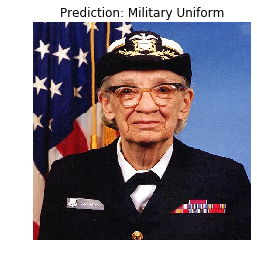

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

### 第二部分

在这个部分我们将使用完全的MobileNet去看看在Cats&Dogs上的表现

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80,20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

W0522 07:00:27.241295 140563116799872 cats_vs_dogs.py:107] 1738 images were corrupted and were skipped


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


但是数据集中的猫猫狗狗图像并不全是相同大小的

In [0]:
for i, example_image in enumerate(train_examples.take(3)):
  print('Image {} Shape: {}'.format(i+1, example_image[0].shape))

Image 1 Shape: (500, 343, 3)
Image 2 Shape: (375, 500, 3)
Image 3 Shape: (375, 500, 3)


因此，我们需要让图像重新回到MobileNet中期望的图像形状(224, 224)

这里不需要.repeat()以及steps_per_epoch，这样每个epoch会节省15s左右，因为shuffle缓冲区每次仅冷启动一次

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

#### 在一个batch的图像中运行分类器

这个时候我们的模型依然是MobileNet的全部(ImageNet训练过)，而不是去掉最后输出层的模型，这样他的输出就有1000个可能的类型，ImageNet中有很多猫猫狗狗，我们来看看它能不能预测我们数据集中的猫猫狗狗

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Siamese cat', 'bluetick', 'tabby', 'cocker spaniel',
       'Siberian husky', 'lab coat', 'Labrador retriever',
       'German shepherd', 'komondor', 'Egyptian cat', 'tabby', 'kelpie',
       'Staffordshire bullterrier', 'basenji', 'dishwasher', 'lynx',
       'Cardigan', 'German short-haired pointer', 'Persian cat',
       'whippet', 'Appenzeller', 'Tibetan mastiff', 'golden retriever',
       'Egyptian cat', 'Siamese cat', 'flat-coated retriever',
       'American Staffordshire terrier', 'Border terrier', 'Siamese cat',
       'Persian cat', 'computer keyboard', 'German shepherd'],
      dtype='<U30')

似乎我们的结果很符合，我们把图像和标签对应显示起来

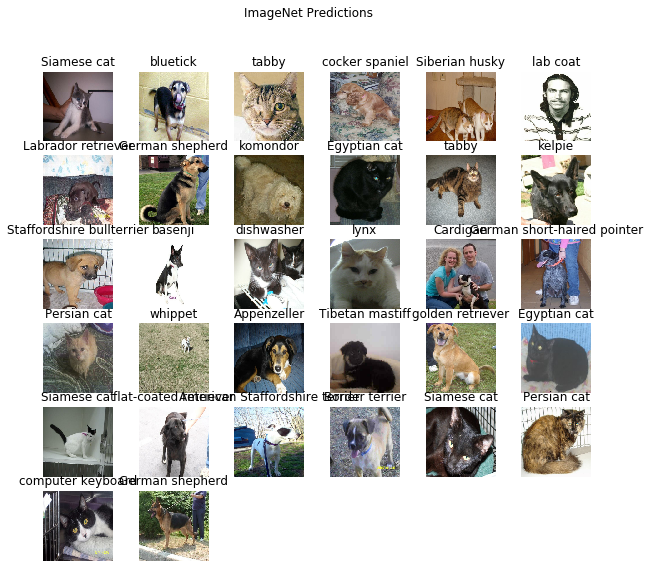

In [0]:
plt.figure(figsize=(10,9))
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet Predictions")

### 第三部分

用Tensorflow Hub做简单的迁移学习

利用迁移学习，我们利用已训练模型的部分层并修改最后一层(或者几层)，然后在我们的数据集上进行再训练

除了完整的模型，Tensorflow Hub上也有很多除去了最后分类层的模型，这些很容易用到迁移学习上，我们这里继续使用MobileNet v2因为这里我们将在移动设备上利用Tensorflow Lite去部署这个模型，任何tfhub.dev中的[图像特征向量检测器](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2)都是可用的

这里我们继续使用猫狗数据集，然后和前面的进行比较

我们把除去最后一层的Tensorflow Hub的模型叫做特征提取器(可以通过feature vector进行搜索)，因为它提取出了图像的各种特征

In [0]:
_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

让我们用这个去跑一个batch，并看看最后一层输出的shape，32是一个batch中图像的数目，1280则是这个模型最后一层特征提取器(filters)的数目

In [0]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


然后我们这里需要冻结模型，让模型前面的层都不能训练

In [0]:
feature_extractor.trainable = False

#### 为我们的模型增加最后层

In [0]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### 进行模型训练

通过model的compile进行训练

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
history = model.fit(train_batches, 
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 79s 136ms/step - loss: 0.1764 - acc: 0.9634 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 75s 129ms/step - loss: 0.1702 - acc: 0.9655 - val_loss: 0.1548 - val_acc: 0.9718
Epoch 3/10
582/582 [==============================] - 76s 130ms/step - loss: 0.1665 - acc: 0.9671 - val_loss: 0.1552 - val_acc: 0.9707
Epoch 4/10
582/582 [==============================] - 75s 129ms/step - loss: 0.1636 - acc: 0.9689 - val_loss: 0.1558 - val_acc: 0.9698
Epoch 5/10
582/582 [==============================] - 74s 128ms/step - loss: 0.1612 - acc: 0.9703 - val_loss: 0.1565 - val_acc: 0.9705
Epoch 6/10
582/582 [==============================] - 73s 126ms/step - loss: 0.1592 - acc: 0.9712 - val_loss: 0.1574 - val_acc: 0.9694
Epoch 7/10
582/582 [==============================] - 73s 125ms/step - loss: 0.1575 - acc: 0.9721 - val_loss: 0.1584 - val_acc: 0.9685
Epoch 8/10
582/582 [===========================

可以看到我们的模型达到97%的准确率，这是因为MobileNet设计精妙并且在大量的数据集进行过训练

我们可以在[这里](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)看到MobieNet是如何创造出来的

我们来画一下训练过程中的损失函数

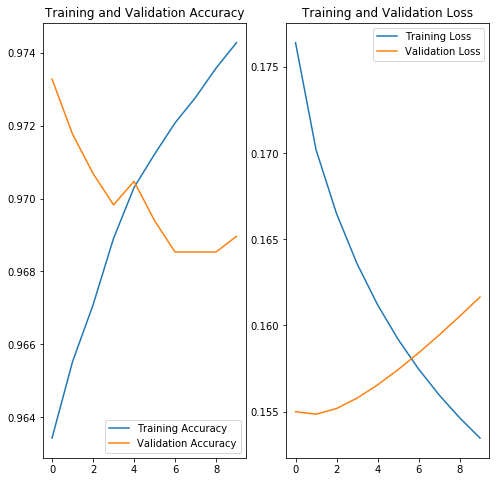

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

比较奇怪的是，有一段时间，在验证集上的性能比训练集还要好，一个原因是验证集是在Epoch结束时候进行检测的，而训练是整个Epoch的平均值

但是，更重要的一点原因是，我们的MobileNet已经在猫猫狗狗上面做过大量的训练了，在训练的过程中，我们的网络在针对训练图像进行图像扩增，但没有在验证集上执行，这意味着与验证集中正常图像相比，训练集图像更难分类

#### 检查模型准确性

首先我们先获取类标签名

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

然后让我们模型跑一个batch，然后查看对应输出的标签及对应名称

In [0]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'cat', 'cat', 'dog'], dtype='<U3')

In [0]:
print('Labels: ', label_batch)
print('Predicted labels: ',predicted_ids)

Labels:  [0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1]
Predicted labels:  [0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1]


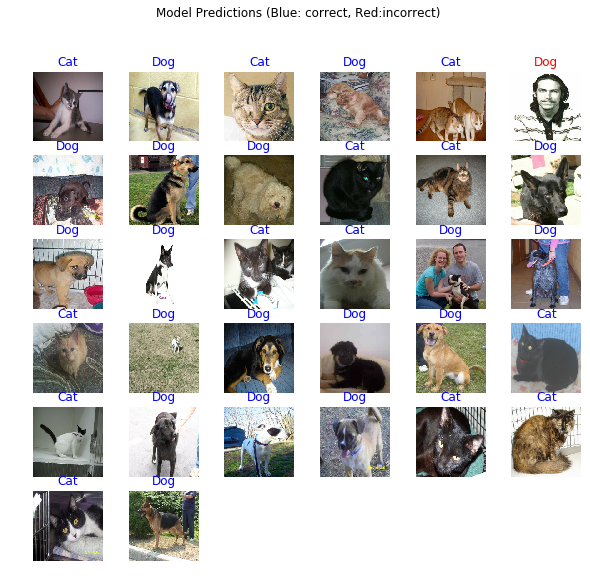

In [0]:
plt.figure(figsize=(10,9))
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model Predictions (Blue: correct, Red:incorrect)')

### 第四部分(Exercise)

这部分将利用之前的花数据库进行迁移学习的练习

首先，安装相关库

In [0]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

然后引入相关库

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

下载花朵相关数据集，这里我们将按照7:3去分割数据集为训练集与验证集

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(70, 30))

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', split=splits, as_supervised=True, with_info=True)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


输出相关信息

In [0]:
num_classes = dataset_info.features['label'].num_classes
# info.splits['train'].num_examples 获取的其实是全部的数目，因此我们这里要逐个获取
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
  
for example in validation_set:
  num_validation_examples += 1

print("Total number of classes: {}".format(num_classes))
print("Total number of training images: {}".format(num_training_examples))
print('Total number of validation images: {}'.format(num_validation_examples))

Total number of classes: 5
Total number of training images: 2590
Total number of validation images: 1080


但是数据库中的图像也并不是全相同大小的

In [0]:
for i, example in enumerate(training_set.take(5)):
  print("Images: {}, Shape: {}, Label: {}".format(i+1, example[0].shape, example[1]))

Images: 1, Shape: (240, 320, 3), Label: 0
Images: 2, Shape: (240, 320, 3), Label: 3
Images: 3, Shape: (240, 180, 3), Label: 3
Images: 4, Shape: (223, 320, 3), Label: 0
Images: 5, Shape: (240, 180, 3), Label: 3


归一化图像，然后构造一个Batch

In [0]:
IMG_RES = 224

def format_image(image, label):
  
  image = tf.image.resize(image, (IMG_RES,IMG_RES))/255.0
  
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

准备迁移学习

In [0]:
_URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/3' # 我们也可以选择inception模型，不过这个模型的输入形状不同要注意
feature_extractor = hub.KerasLayer(_URL, input_shape=(IMG_RES, IMG_RES, 3))

冻结特征参数

In [0]:
feature_extractor.trainable = False

添加最后层

In [0]:
model = tf.keras.Sequential([
    feature_extractor, 
    layers.Dense(units=num_classes, activation='softmax')
])

进行编译

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

EPOCHS = 6

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


开始训练

In [0]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 18s 225ms/step - loss: 0.9657 - acc: 0.6699 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 9s 114ms/step - loss: 0.5351 - acc: 0.8440 - val_loss: 0.8879 - val_acc: 0.6907
Epoch 3/6
81/81 [==============================] - 10s 120ms/step - loss: 0.4462 - acc: 0.8849 - val_loss: 0.8559 - val_acc: 0.7167
Epoch 4/6
81/81 [==============================] - 10s 119ms/step - loss: 0.3944 - acc: 0.9042 - val_loss: 0.8408 - val_acc: 0.7269
Epoch 5/6
81/81 [==============================] - 9s 114ms/step - loss: 0.3573 - acc: 0.9139 - val_loss: 0.8351 - val_acc: 0.7324
Epoch 6/6
81/81 [==============================] - 9s 113ms/step - loss: 0.3281 - acc: 0.9259 - val_loss: 0.8353 - val_acc: 0.7352


训练完成，我们大约可以得到92%的准确率，然而v2只有88%，说明v3性能更好，而且比我们之前的网络训练80个epochs好更多

训练数据查看

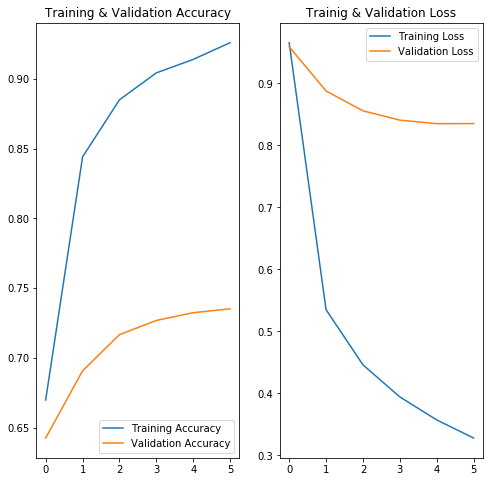

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Trainig & Validation Loss')
plt.show()

进行预测

In [0]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


获取一个Batch

In [0]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'tulips' 'dandelion' 'daisy' 'sunflowers' 'daisy' 'dandelion'
 'daisy' 'dandelion' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'daisy'
 'daisy' 'roses' 'dandelion' 'sunflowers' 'tulips' 'daisy' 'dandelion'
 'tulips' 'tulips' 'daisy' 'tulips' 'tulips' 'daisy' 'daisy' 'sunflowers'
 'sunflowers' 'dandelion' 'sunflowers']


输出预测的标签以及真值标签

In [0]:
print('Predicted Labels: {}'.format(predicted_ids))
print('True Labels: {}'.format(label_batch))

Predicted Labels: [2 2 0 1 3 1 0 1 0 0 2 2 3 1 1 4 0 3 2 1 0 2 2 1 2 2 1 1 3 3 0 3]
True Labels: [2 2 0 3 3 3 0 1 0 0 2 2 3 0 3 4 0 4 2 1 0 2 2 1 2 2 3 4 3 3 0 3]


输出模型的预测结果(蓝色为正确，红色为错误)

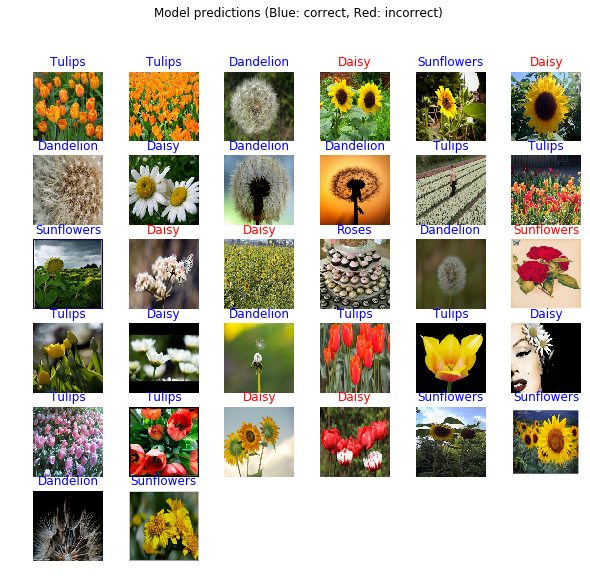

In [0]:
plt.figure(figsize=(10,9))
for n in range(BATCH_SIZE):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (Blue: correct, Red: incorrect)')

## SPP-net

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [0]:
def SPP_layer()

In [0]:
keras.Sequential([
    layers.Conv2D(activation=tf.nn.relu, name='conv_layer_1'),
    layers.MaxPooling2D(name='pooling_layer_1'),
    layers.Conv2D(activation=tf.nn.relu, name='conv_layer_2'),
    layers.MaxPooling2D(name='pooling_layer_2'),
    layers.Conv2D(activation=tf.nn.relu, name='conv_layer_3'),
    layers.Conv2D(activation=tf.nn.relu, name='conv_layer_4'),
    layers.Conv2D(activation=tf.nn.relu, name='conv_layer_5'),
    # TODO SPP layer
    layers.S
    layers.Dense(, activation=tf.nn.relu, name='fc_layer_1'),
    layers.Dropout(, name='dp_layer_1'),
    layers.Dense(, activation=tf.nn.relu, name='fc_layer_2'),
    layers.Dropout(, name='dp_layer_2'),
    layers.Dense(, activation=tf.nn.relu, name='fc_layer_3'),
    layers.Softmax(, name='output_layer')
])